### Power Spectra Noise Calculation

Computes and analyzes CMB power spectra for signal and noise. 

- Reads pre-computed PySM sky maps (signal) and noise simulations.
- Applies a Galactic mask and computes power spectra (TT, EE, BB, TE, TB, EB) using NaMaster.
- Runs 100 simulations for "signal + noise" and "noise-only" cases.
- Saves spectra for error estimation (noise and total errors).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
from tqdm import tqdm

In [7]:
# Read pre-computed PYSM simulated sky map without noise
pysm_sky_23 =  hp.read_map('../results/maps/total_23GHz_0512_fwhm_5280.fits', field=[0,1,2], dtype=np.float64)
pysm_sky_23 *= 1e-3 # in mK

# Read Mask
mask = hp.read_map('../results/masks/mask_galcut10_apodC2_5.fits')

# Define parameters
n_sim = 100
nside = 512
npix = hp.nside2npix(nside)
lmax = 2*nside
dl = 10

Compute Power Spectra, $C_{\ell}$ for each noise simulation (100 of them). This last cell may take a few hours.  

In [ ]:
import sys

sys.path.append("../")
from main.utils import auto_spectrum


for ii in tqdm(range(n_sim), desc="Computing power spectra: "):
    noise_23 = hp.read_map(
        "../results/noise_simulations/wmap_k_noise_" + str(ii + 1).zfill(4) + ".fits",
        field=[0, 1, 2],
    )

    sky_noise_23 = pysm_sky_23 + noise_23

    cl_sky_23_10 = auto_spectrum(
        mask,
        sky_noise_23,
        lmax=lmax,
        dl=dl,
        nside=nside,
        purify_e=True,
        purify_b=True,
        beam=None,
    )
    cl_noise_23_10 = auto_spectrum(
        mask,
        noise_23,
        lmax=lmax,
        dl=dl,
        nside=nside,
        purify_e=True,
        purify_b=True,
        beam=None,
    )

    names_auto = ["ell", "TT", "EE", "BB", "TE", "TB", "EB"]
    names_cross = ["ell", "T1T2", "E1E2", "B1B2", "E1B2", "E2B1", "null"]

    # Power Spectra of Noise
    with open(
        "../results/errorbars/cl_sky_noise/cl_sky_noise_"
        + str(ii + 1).zfill(4)
        + "_23ghz_galcut10.txt",
        "w",
    ) as f:
        f.write("\t".join(names_auto) + "\n")
        np.savetxt(f, cl_sky_23_10, fmt="%.12e", delimiter="\t")

    # Power Spectra of WMAP SIM + Noise.
    with open(
        "../results/errorbars/cl_noise/cl_noise_"
        + str(ii + 1).zfill(4)
        + "_23ghz_galcut10.txt",
        "w",
    ) as f:
        f.write("\t".join(names_auto) + "\n")
        np.savetxt(f, cl_noise_23_10, fmt="%.12e", delimiter="\t")

plot the resulting power spectra (TT)

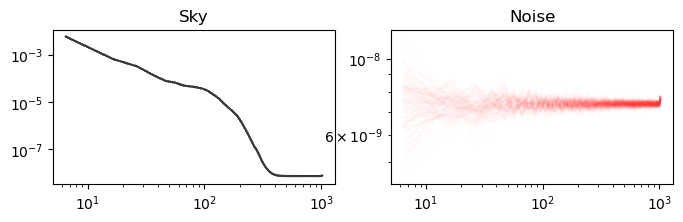

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))

for ii in range(n_sim):
    cl_sky = np.loadtxt('../results/errorbars/cl_sky_noise/cl_sky_noise_' +str(ii+1).zfill(4) + '_23ghz_galcut10.txt',  skiprows=1)
    cl_noise= np.loadtxt('../results/errorbars/cl_noise/cl_noise_' +str(ii+1).zfill(4) + '_23ghz_galcut10.txt',  skiprows=1)

    axs[0].plot(cl_sky[0,:], cl_sky[1,:], c='k', alpha=0.011)
    axs[1].plot(cl_noise[0,:], cl_noise[1,:], c='r', alpha=0.011)

axs[0].set_title('Sky')
axs[1].set_title('Noise')

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')